In [16]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
import scanpy as sc

In [18]:
from pca import LowRank, n2s_low_rank

# Concavity of sqrt

In [19]:
lam = np.power(10.001, np.arange(-2, 2, 0.1))

In [20]:
sampling = 0
N = 100000
for i in range(N):
    sampling+= np.sqrt(np.random.poisson(lam))
sampling = sampling/N

ValueError: x and y must have same first dimension, but have shapes (40,) and (1277, 22415)

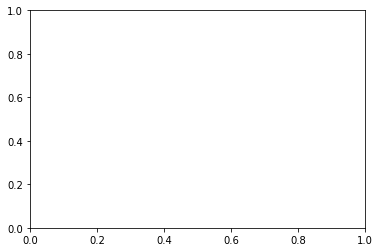

In [29]:
plt.plot(lam, y, label='expected output')
plt.plot(lam, np.sqrt(lam), label = 'sqrt mean')

plt.xscale('log')
plt.legend()
plt.title("Expectation is sqrt at large values")

In [ ]:
plt.plot(lam, y/np.sqrt(lam), label = 'compare to sqrt')
plt.plot(lam, y/lam, label = 'compare to mean')
plt.xscale('log')
plt.legend()
plt.title("Expectation is mean at low values")

In [37]:
from scipy.special import factorial

In [38]:
def expected_sqrt(mean):
    """Return expected square root of a poisson distribution. Expects ndarray input.
    Uses Taylor series centered at 0 or mean, as appropriate."""
    
    truncated_taylor_around_0 = np.zeros(mean.shape)
    nonzeros = (mean != 0)
    mean = mean + 1e-8
    small_values = mean*(mean < 4)
    for k in range(15):
        truncated_taylor_around_0 += small_values**k/factorial(k) * np.sqrt(k)
    truncated_taylor_around_0 *= np.exp(-small_values)
    
    truncated_taylor_around_mean = np.sqrt(mean) - np.sqrt(mean)**(-0.5)/8 + np.sqrt(mean)**(-1.5)/16
    
    return nonzeros*(truncated_taylor_around_0 * (mean < 4) + truncated_taylor_around_mean * (mean >= 4))

In [ ]:
plt.scatter(expected_sqrt(lam), sampling)
plt.xlabel("Taylor series")
plt.ylabel("Sampling")
plt.title("Sampling agrees with theory.")

In [ ]:
plt.plot(lam, expected_sqrt(lam)/np.sqrt(lam), label = 'compare to sqrt')
plt.plot(lam, expected_sqrt(lam)/lam, label = 'compare to mean')
plt.xscale('log')
plt.legend()
plt.title("Expectation is mean at low values")

# HCA

In [64]:
hca = sc.read('/Users/josh/src/noise2self-single-cell/data/hca/hca_marrow_deep.h5ad')
hca_down = sc.pp.downsample_counts(hca, 2000, replace = False, copy = True)

In [72]:
y = np.array(hca.X.todense())
x = np.array(hca_down.X.todense()).astype(np.int)

In [73]:
mean = y/y.sum(axis = 1, keepdims = True) * 2000

In [74]:
z = expected_sqrt(mean)

5


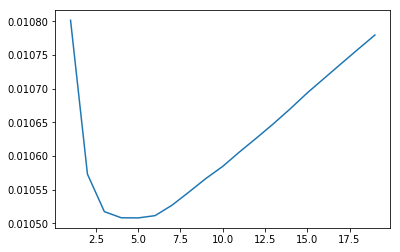

In [75]:
# X is a matrix of integer counts

import numpy as np
from sklearn.utils.extmath import randomized_svd

x1 = np.random.binomial(x, 0.5)
x2 = x - x1

x1_norm = np.log1p(x1)
x2_norm = np.log1p(x2)

def mse(x, y):
    return ((x - y)**2).mean()

U, S, V = randomized_svd(np.sqrt(x1_norm), n_components=50, random_state=42)

loss = []
k_range = np.arange(1, 20)
for k in k_range:
    x_pred = U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:])
    loss.append(mse(x_pred, x2_norm))
    
k_opt = k_range[np.argmin(loss)]
                
print(k_opt)
plt.plot(k_range, loss)

6


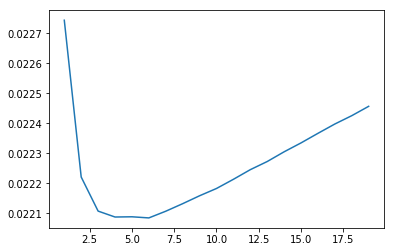

In [76]:
# X is a matrix of integer counts

import numpy as np
from sklearn.utils.extmath import randomized_svd

x1 = np.random.binomial(x, 0.5)
x2 = x - x1

x1_norm = np.sqrt(x1)
x2_norm = np.sqrt(x2)

def mse(x, y):
    return ((x - y)**2).mean()

U, S, V = randomized_svd(np.sqrt(x1_norm), n_components=50, random_state=42)

loss = []
k_range = np.arange(1, 20)
for k in k_range:
    x_pred = U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:])
    loss.append(mse(x_pred, x2_norm))
    
k_opt = k_range[np.argmin(loss)]
                
print(k_opt)
plt.plot(k_range, loss)

In [57]:
x1 = np.random.poisson(mean)
x2 = np.random.poisson(mean)

In [ ]:
def mse(x, y):
    return ((x - y)**2).mean()

In [ ]:
mse(np.sqrt(x1), np.sqrt(x2)), mse(np.sqrt(x1), z) + mse(np.sqrt(x2), z)

In [ ]:
from sklearn.utils.extmath import randomized_svd

U, S, V = randomized_svd(np.sqrt(x1), n_components=100, random_state=42)

In [ ]:
ss_loss, gt_loss = [], []
for k in np.arange(1, 20):
    x = U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:])
    ss_loss.append(mse(x, np.sqrt(x2)))
    gt_loss.append(mse(x, z))

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(ss_loss)
ax1.set_title("Self-Supervised Loss Reveals Best Parameters")
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(gt_loss, '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Principal Components')

In [ ]:
# Negative log likelihood
def poisson_log_lik(lam, k):
    return (lam - k*np.log(lam)).mean()

In [ ]:
ss_loss, gt_loss = [], []
for k in np.arange(1, 20):
    x = U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:])
    ss_loss.append(poisson_log_lik(x**2 + 1e-3, x2))
    gt_loss.append(poisson_log_lik(x**2 + 1e-3, mean))

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(ss_loss)
ax1.set_title("Self-Supervised Loss Reveals Best Parameters")
ax1.set_ylabel('Self-Supervised Poisson Loss')
ax2.plot(gt_loss, '--')
ax2.set_ylabel('Ground-Truth Poisson Loss')
ax2.set_xlabel('Principal Components')

# MAGIC

In [58]:
import magic
from util import normalize_rows
max_t=20
lazy_p=1

median_counts = np.median(x1.sum(axis=1)) / 2

X1 = np.sqrt(normalize_rows(x1, median_counts))
X2 = np.sqrt(normalize_rows(x2, median_counts))

magic_op = magic.MAGIC()
magic_op.fit(X1)

diff_op = np.array(magic_op.diff_op.todense())

diff_op = lazy_p * diff_op + (1 - lazy_p) * np.eye(diff_op.shape[0])

Running MAGIC on 1277 cells and 22415 genes.
Calculating graph and diffusion operator...
  Calculating PCA...


/Users/josh/.local/lib/python3.6/site-packages/magic/magic.py:376: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn("Input matrix contains unexpressed genes. "


  Calculated PCA in 4.13 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.30 seconds.
  Calculating affinities...
  Calculated affinities in 0.51 seconds.
Calculated graph and diffusion operator in 5.00 seconds.


In [59]:
denoised = x1
ss_losses = []
gt_losses = []

max_t = 7

for i in range(max_t):
    print(i)
    normalized_denoised = denoised/denoised.sum(axis = 1, keepdims = True) * x2.sum(axis = 1, keepdims = True)
    gt = z/z.sum(axis = 1, keepdims = True) * x2.sum(axis = 1, keepdims = True)
    ss_loss = mse(np.sqrt(normalized_denoised), np.sqrt(x2))
    gt_loss = mse(np.sqrt(normalized_denoised), z)
    
    ss_losses.append(ss_loss)
    gt_losses.append(gt_loss)
    print(ss_loss - gt_loss, gt_loss)
    denoised = diff_op.dot(denoised)

0
0.028429079114365555 0.028444344271504073
1
0.028358806752367613 0.015635292831692002
2
0.028352581875456317 0.015798034995369515


KeyboardInterrupt: 

In [63]:
denoised = x1[:,:100]
ss_losses = []
gt_losses = []

max_t = 7

for i in range(max_t):
    print(i)
    normalized_denoised = denoised/denoised.sum(axis = 1, keepdims = True) * x2[:,:100].sum(axis = 1, keepdims = True)
    ss_loss = mse(np.sqrt(normalized_denoised), np.sqrt(x2[:,:100]))
    gt_loss = mse(np.sqrt(normalized_denoised), z[:,:100])
    
    ss_losses.append(ss_loss)
    gt_losses.append(gt_loss)
    print(ss_loss, gt_loss)
    denoised = diff_op.dot(denoised)

0
nan nan
1
0.03157073473641807 0.013516790264198579
2
0.03145335847484202 0.01340133191810291
3
0.03147353234571222 0.013420394984443433
4
0.03147589226200873 0.013425285526974756
5
0.0314751416577437 0.01342703265026979
6
0.0314747867212766 0.013428540171863521


/Users/josh/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Text(0.5,0,'Diffusion Time')

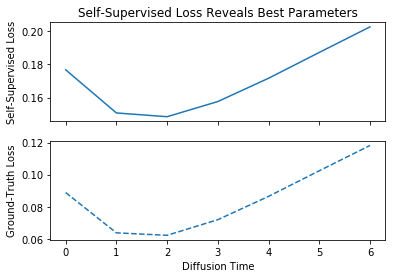

In [219]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(ss_losses)
ax1.set_title("Self-Supervised Loss Reveals Best Parameters")
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(gt_losses, '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Diffusion Time')

In [216]:
denoised = x1
ss_losses = []
gt_losses = []

max_t = 15

for i in range(max_t):
    print(i)
    normalized_denoised = denoised/denoised.sum(axis = 1, keepdims = True) * x2.sum(axis = 1, keepdims = True)
    ss_loss = poisson_log_lik(normalized_denoised + 1e-3, x2)
    gt_loss = poisson_log_lik(normalized_denoised + 1e-3, mean)
    
    ss_losses.append(ss_loss)
    gt_losses.append(gt_loss)
    denoised = diff_op.dot(denoised)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


Poisson loss wants to diffuse a lot

Text(0.5,0,'Principal Components')

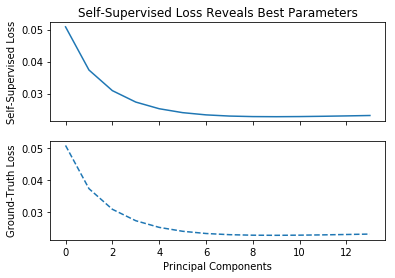

In [217]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(ss_losses[1:])
ax1.set_title("Self-Supervised Loss Reveals Best Parameters")
ax1.set_ylabel('Self-Supervised Loss')
ax2.plot(gt_losses[1:], '--')
ax2.set_ylabel('Ground-Truth Loss')
ax2.set_xlabel('Principal Components')

# Poisson Matrix Factorization

In [166]:
from sparse_poisson import PoissonMF

In [180]:
y = np.vstack([hca.X.tocoo().row, hca.X.tocoo().col, hca.X.tocoo().data.astype(np.int)]).T

In [185]:
import sparse_poisson as sp

poisson = sp.PoissonMF(n_components=15,max_iter=1000,smoothness=0.1,verbose=True,tol=0.0001,a=0.1,b=0.1)
poisson.fit(y)

cols= 18937
rows= 1277
	After ITERATION: 0	Objective: -2957683537.06	Old objective: -inf	Improvement: nan

/Users/josh/src/noise2self-single-cell/src/noise2self_sc/sparse_poisson.py:172: RuntimeWarning: invalid value encountered in double_scalars
  bound = self._bound(X)


	After ITERATION: 47	Objective: 173344277.07	Old objective: 173316422.18	Improvement: 0.000161

KeyboardInterrupt: 

In [ ]:
poisson.

In [13]:
from scipy.sparse import issparse
def cor(X, Y):
    if issparse(X):
        X = np.array(X.todense())
    if issparse(Y):
        Y = np.array(Y.todense())
    return np.corrcoef(X.ravel(), Y.ravel())[0, 1]

In [14]:
print("Original correlation: ", cor(hca_down.X.sqrt(), hca.X.sqrt()))

Original correlation:  0.7802032108454697


In [15]:
print("Denoised correlation: ", cor(np.sqrt(denoised_hca.X), hca.X.sqrt()))

NameError: name 'denoised_hca' is not defined

In [ ]:
print("Denoised correlation: ", cor(np.sqrt(denoised_hca_pca.X), hca.X.sqrt()))

In [174]:
from util import poisson_expected_sqrt
expected_sqrt = poisson_expected_sqrt(np.array(hca.X.todense())/np.array(hca.X.todense()).sum(axis = 1, keepdims = True)*2000, 30)

# Simulation

In [162]:
import pickle
with open('/Users/josh/src/noise2self-single-cell/data/sim/dataset_0.pickle', 'rb') as fp:
    exp, class_labels, programs, lib_size, umis_X, umis_Y = pickle.load(fp)

In [163]:
true_means = np.exp(exp.dot(programs))

In [164]:
model = LowRank()
best_rank, rank_range, losses = model.sweep(umis_X, umis_Y, 30)

Optimal rank: 3


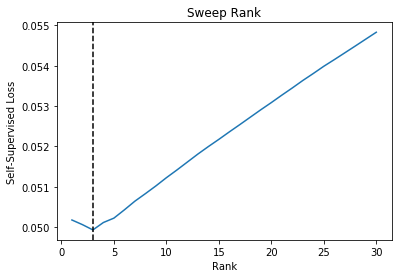

In [165]:
plt.plot(rank_range, losses)
plt.xlabel("Rank")
plt.ylabel("Self-Supervised Loss")
plt.title("Sweep Rank")
plt.axvline(best_rank, color="k", linestyle="--")

denoised = model.fit_transform(umis_X, umis_Y)

In [148]:
umis_X = paul.X

In [159]:
from sklearn.utils.extmath import randomized_svd

U, S, V = randomized_svd(np.sqrt(umis_X), 9)

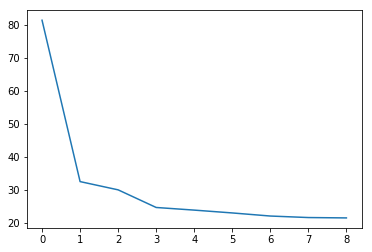

In [161]:
plt.plot(S)

(0, 1)

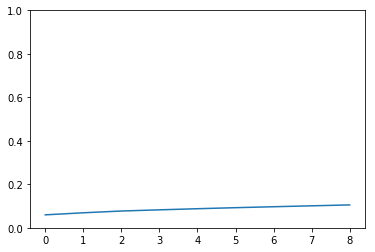

In [160]:
plt.plot((S*S).cumsum()/umis_X.sum())
plt.ylim(0,1)

In [137]:
denoised_sqrt = U.dot(np.diag(S)).dot(V)

In [139]:
denoised_sqrt = np.maximum(denoised_sqrt, 0)

In [133]:
correlation(denoised_sqrt.ravel(), np.sqrt(true_means).ravel())

ValueError: operands could not be broadcast together with shapes (26062511,) (2097152,) 

In [140]:
(denoised_sqrt*denoised_sqrt).sum(1)

array([2478.45  , 5567.8955, 4926.566 , ..., 3890.741 , 3409.2192,
       8071.7227], dtype=float32)

In [138]:
(denoised_sqrt*denoised_sqrt).sum(1)

array([2478.5254, 5568.3613, 4927.9585, ..., 3891.8545, 3409.6824,
       8071.7256], dtype=float32)

In [141]:
umis_X.sum(1)

array([ 4031.,  7741.,  7064., ...,  5689.,  5216., 10358.], dtype=float32)

In [55]:
from scipy.spatial.distance import correlation

In [73]:
(denoised*denoised).sum(), umis_X.sum()

(536.7738869945135, 111218)

In [56]:
correlation(np.sqrt(denoised).ravel(), np.sqrt(true_means).ravel())

0.37145616356605593

In [57]:
correlation(np.sqrt(umis_X).ravel(), np.sqrt(true_means).ravel())

0.8376143837983456

In [58]:
adata = sc.AnnData(X = umis_X)

In [ ]:
adata = 

# Stability of PC Regression

In [11]:
paul = sc.datasets.paul15()

... 100%

... storing 'paul15_clusters' as categorical


Optimal rank: 16


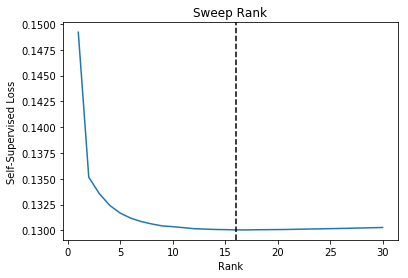

In [37]:
denoised_adata = n2s_low_rank(paul, regression=True)

In [ ]:
V = np.random.randn(500,5)
W = np.random.randn(5, 200)
L = (V.dot(W))
L = L/(np.max(L))*3

X1 = np.random.randn(V)
X2 = np.random.randn(W)

In [30]:
X = paul.X

X = X.astype(np.int)
np.random.seed(0)
X1 = np.random.binomial(X, 0.5)
X2 = X - X1

In [31]:
x = np.sqrt(denoised_adata.X)

In [36]:
rank_range = np.arange(1, 25, 2)
diff_from_opt = np.zeros(len(rank_range))
for i, r in enumerate(rank_range):
    model = LowRank(r, regression=True)
    y = model.fit_transform(X1, X2)
    diff = ((np.sqrt(y) - x)**2).mean()
    diff_from_opt[i] = diff
    print(r, ': ', diff)

1 :  0.02056164118959706
3 :  0.004906760324514881
5 :  0.0027534155659403267
7 :  0.0017187939439523943
9 :  0.001070357292043151
11 :  0.0006869342945542818
13 :  0.0003826122756931465
15 :  0.00018943817572063054
17 :  0.0002420149088303624
19 :  0.00037286476600429703
21 :  0.0005304636046424481
23 :  0.0006268238246982786


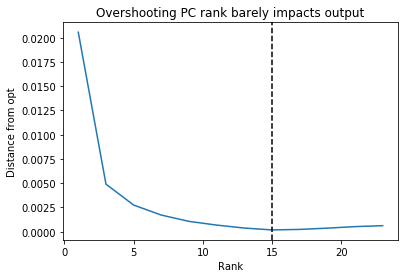

In [46]:
plt.plot(rank_range, diff_from_opt)
plt.xlabel("Rank")
plt.ylabel("Distance from opt")
plt.title("Overshooting PC rank barely impacts output")
plt.axvline(rank_range[np.argmin(diff_from_opt)], color='k', linestyle='--')

# Coefficients 

Given a matrix X which we write as $U S V$ and approximate as $U_r S_r V_r$, we may consider the PC regression to $Y$. That is,
we try to predict $Y$ from the feature matrix $X V_r^t S_r^{-1}= U_r$.

The regression map $W: \mathbb{R}^r \rightarrow \mathbb{R}^n$ is given by 

$W = U_r^t Y,$

since the feature matrix is orthogonal.

The weights for the $k^{th}$ PC are given by the $k^{th}$ row of that matrix. In particular, they do not depend on the choice of rank $r > k$.

(Note: there are two ways to view this. We may project the data $X$ orthogonally into PC space (in which case higher PCs will have low weight), or we may take it's coordinates in PC space (in which case all PCs will have equal weight). We choose the latter, since it shows that for the PCs with noisy values very little gets used. This is equivalent to dividing by $S_r$ after projection, which just shifts that term from $W$ over to the feature matrix.)

In [93]:
from scipy.sparse import issparse

X = paul.X
#X = hca_down.X

if issparse(X):
    X = np.array(X.todense())

X = X.astype(np.int)

np.random.seed(0)
X1 = np.random.binomial(X, 0.5)
X2 = X - X1

X1 = np.sqrt(X1)
X2 = np.sqrt(X2)

In [94]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(X1, n_components=100, random_state=42)

In [95]:
W_pcr = U.T.dot(X2)
weight_norm_pcr = (W_pcr*W_pcr).sum(axis = 1)

W_pca = U.T.dot(X1)
weight_norm_pca = (W_pca*W_pca).sum(axis = 1)

The total norm of such coefficients is 1 if we use $X$ to regress $X$. When we are predicting $Y$, then the 
coefficients may drop off.

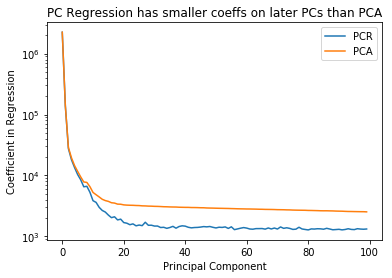

In [96]:
plt.plot(weight_norm_pcr, label = "PCR")
plt.plot(weight_norm_pca, label = "PCA")
plt.title("PC Regression has smaller coeffs on later PCs than PCA")
plt.xlabel("Principal Component")
plt.ylabel("Coefficient in Regression")
plt.yscale("log")
plt.legend()